In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dataset.zip

In [3]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# # Preparing dataset for Stratified Sampling.

# import shutil
# os.mkdir("data")
# os.mkdir("data/noninteracting")
# os.mkdir("data/merger")

# src_train_merger = "dataset_zurich/train/merger/"
# src_val_merger = "dataset_zurich/val/merger/"
# src_train_noninteracting = "dataset_zurich/train/noninteracting/"
# src_val_noninteracting = "dataset_zurich/val/noninteracting/"

# dest_merger = "data/merger/"
# dest_noninteracting = "data/noninteracting/"

# for filename in os.listdir(src_train_merger):
#   shutil.move(os.path.join(src_train_merger, filename), dest_merger)
# for filename in os.listdir(src_val_merger):
#   shutil.move(os.path.join(src_val_merger, filename), dest_merger)

# for filename in os.listdir(src_train_noninteracting):
#   shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
# for filename in os.listdir(src_val_noninteracting):
#   shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

In [6]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [7]:
data_transforms = {
    "train": transforms.Compose([
        # transforms.RandomResizedCrop(225),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(250),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        # transforms.Resize(250),
        transforms.CenterCrop(250),
        # transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        # transforms.Resize(250),
        # transforms.CenterCrop(224),
        # transforms.Resize(200),
        transforms.CenterCrop(250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [38]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

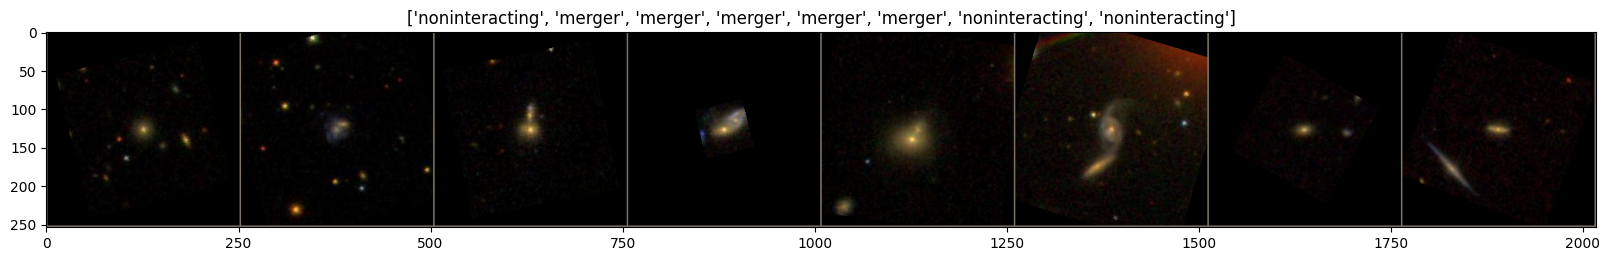

In [39]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 60))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [40]:
class_names

['merger', 'noninteracting']

In [41]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

<Figure size 1500x4000 with 0 Axes>

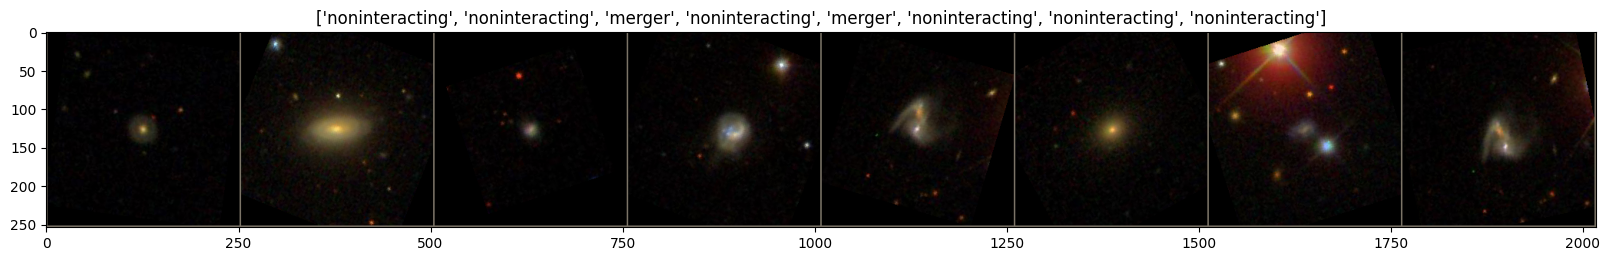

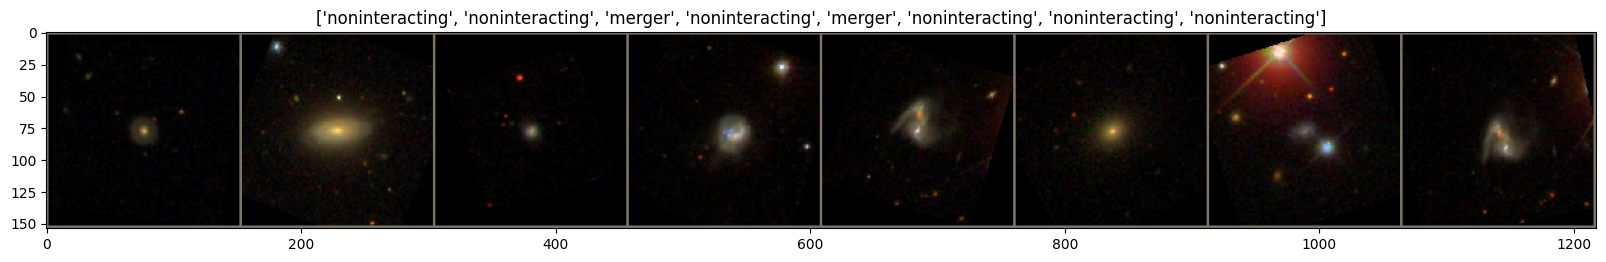

<Figure size 1500x4000 with 0 Axes>

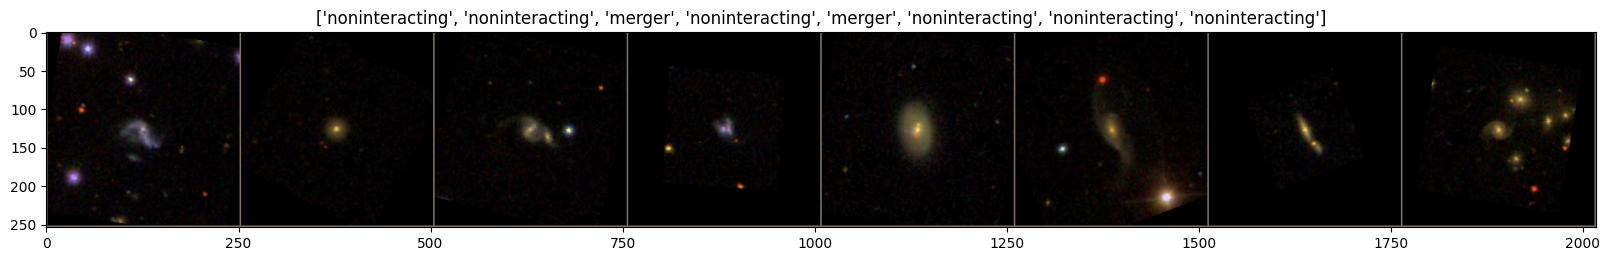

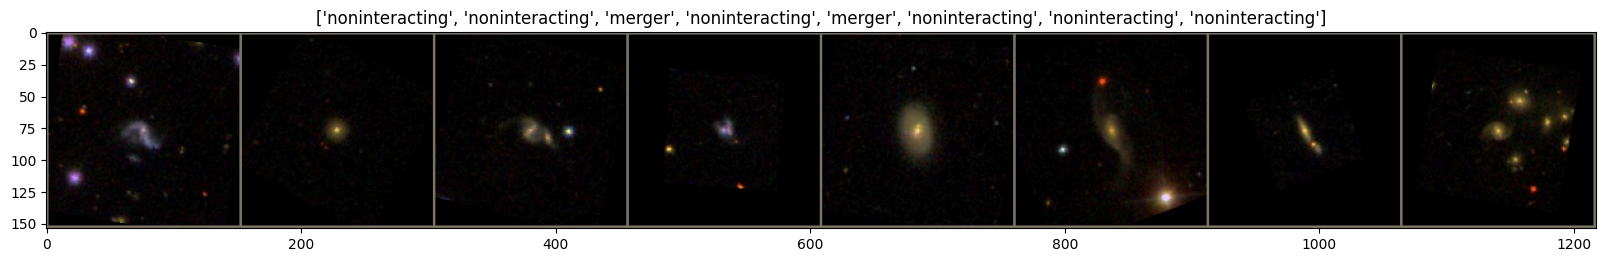

In [51]:
# Visualize the effect of downsampling
inputs, classes = next(iter(dataloaders['train']))

def downsample_check(size=150, mode="nearest"):
  inputs, labels = next(iter(dataloaders['train']))
  
  plt.figure(figsize=(15, 40))
  # "Original (top) vs Downsampled (bottom)"

  if mode == "nearest":
    intrp_inps = F.interpolate(inputs, size=size, mode=mode)
  elif mode == "bicubic":
    intrp_inps = F.interpolate(inputs, size=size, mode=mode, align_corners=True)

  out_intrp = torchvision.utils.make_grid(intrp_inps)
  out = torchvision.utils.make_grid(inputs)

  imshow(out, title=[class_names[x] for x in classes])
  imshow(out_intrp, title=[class_names[x] for x in classes])

downsample_check()
downsample_check(mode="bicubic")

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(1152, 288)
        self.fc2 = nn.Linear(288, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        # clamp is required due to the nature of bicubic interpolation. See "Note" in https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate
        x = F.interpolate(x, size=(150, 150), mode="bicubic", align_corners=True).clamp(min=0, max=255)
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        # x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        # x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
model = model.to(device)

In [10]:
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1152, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [11]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [12]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 6  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            ### EARLY STOPPING ###
            if phase == "val" and epoch_loss < min_val_loss:
              epochs_no_improve = 0
              min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
              epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
              print("Early stopping!")
              return  # Way to come out of all nested loops
            
            ### end ###

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
trained_model = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5680 Acc: 0.7217
val Loss: 0.4593 Acc: 0.8085

Epoch 1/49
----------
train Loss: 0.4589 Acc: 0.8053
val Loss: 0.4376 Acc: 0.8187

Epoch 2/49
----------
train Loss: 0.4326 Acc: 0.8171
val Loss: 0.4004 Acc: 0.8320

Epoch 3/49
----------
train Loss: 0.4137 Acc: 0.8263
val Loss: 0.3832 Acc: 0.8397

Epoch 4/49
----------
train Loss: 0.3968 Acc: 0.8333
val Loss: 0.3779 Acc: 0.8417

Epoch 5/49
----------
train Loss: 0.3828 Acc: 0.8413
val Loss: 0.3721 Acc: 0.8480

Epoch 6/49
----------
train Loss: 0.3778 Acc: 0.8446
val Loss: 0.3705 Acc: 0.8522

Epoch 7/49
----------
train Loss: 0.3790 Acc: 0.8443
val Loss: 0.3754 Acc: 0.8585

Epoch 8/49
----------
train Loss: 0.3677 Acc: 0.8494
val Loss: 0.3553 Acc: 0.8585

Epoch 9/49
----------
train Loss: 0.3592 Acc: 0.8552
val Loss: 0.3389 Acc: 0.8630

Epoch 10/49
----------
train Loss: 0.3561 Acc: 0.8528
val Loss: 0.3406 Acc: 0.8652

Epoch 11/49
----------
train Loss: 0.3489 Acc: 0.8608
val Loss: 0.3360 Acc: 0.8677

Epoch 12/49
----------
t

In [14]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 88.94447223611806


In [15]:
preds_ = np.concatenate([pred.cpu().numpy() for pred in all_preds])

In [16]:
preds_

array([1, 1, 0, ..., 1, 1, 1])

In [17]:
targets_ = np.concatenate([target.cpu().numpy() for target in all_targets])

In [18]:
from sklearn.metrics import  confusion_matrix, classification_report

In [19]:
print(confusion_matrix(targets_, preds_))
print("\n")
print(classification_report(targets_, preds_))

[[1223  275]
 [ 167 2333]]


              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1498
           1       0.89      0.93      0.91      2500

    accuracy                           0.89      3998
   macro avg       0.89      0.87      0.88      3998
weighted avg       0.89      0.89      0.89      3998



In [20]:
!pip install plot-metric

In [21]:
from plot_metric.functions import BinaryClassification

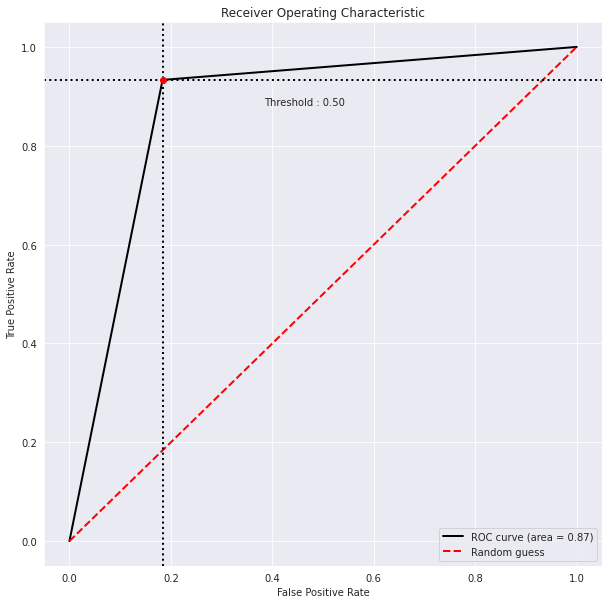

In [22]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds_, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()